In [7]:
import os
import shutil
import pandas as pd

# Directorio de imágenes preprocesadas
IMAGE_DIR = "../04_Extra/ID/IMAGES_PREPROC2"

# Cargar dataset con información de los sets y sus años de retiro
df_lego = pd.read_csv("../01_Data_Cleaning/df_lego_final.csv")

# Filtrar sets con YearExit > 2004
sets_validos = df_lego[df_lego["YearFrom"] >= 2004]["Number"].astype(str).tolist()

# 🔹 1️⃣ Eliminar carpetas con una sola imagen
for set_folder in os.listdir(IMAGE_DIR):
    set_path = os.path.join(IMAGE_DIR, set_folder)
    
    if os.path.isdir(set_path):
        num_images = len(os.listdir(set_path))  # Contar imágenes en la carpeta
        
        # Si solo hay 1 imagen o el set no está en la lista de sets válidos, eliminar carpeta
        if num_images <= 1 or set_folder not in sets_validos:
            shutil.rmtree(set_path)  # Eliminar carpeta y contenido
            print(f"❌ Eliminado: {set_folder} (Imágenes: {num_images}, YearFrom > 2004)")


❌ Eliminado: 4729 (Imágenes: 2, YearFrom > 2004)
❌ Eliminado: 5002930 (Imágenes: 1, YearFrom > 2004)
❌ Eliminado: 471518 (Imágenes: 1, YearFrom > 2004)
❌ Eliminado: 11940 (Imágenes: 1, YearFrom > 2004)
❌ Eliminado: 912302 (Imágenes: 1, YearFrom > 2004)
❌ Eliminado: 9694 (Imágenes: 0, YearFrom > 2004)
❌ Eliminado: 66678 (Imágenes: 1, YearFrom > 2004)
❌ Eliminado: 662409 (Imágenes: 1, YearFrom > 2004)
❌ Eliminado: 76277 (Imágenes: 0, YearFrom > 2004)
❌ Eliminado: 3365 (Imágenes: 0, YearFrom > 2004)
❌ Eliminado: 1600 (Imágenes: 2, YearFrom > 2004)
❌ Eliminado: 76045 (Imágenes: 0, YearFrom > 2004)
❌ Eliminado: 60120 (Imágenes: 0, YearFrom > 2004)
❌ Eliminado: 30650 (Imágenes: 0, YearFrom > 2004)
❌ Eliminado: 41091 (Imágenes: 0, YearFrom > 2004)
❌ Eliminado: 76421 (Imágenes: 0, YearFrom > 2004)
❌ Eliminado: 892312 (Imágenes: 0, YearFrom > 2004)
❌ Eliminado: 30006 (Imágenes: 1, YearFrom > 2004)
❌ Eliminado: 10401 (Imágenes: 0, YearFrom > 2004)
❌ Eliminado: 45603 (Imágenes: 1, YearFrom > 2004

In [ ]:
df_lego

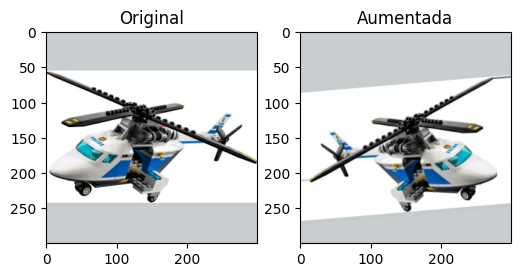

Found 24849 images belonging to 2919 classes.

✅ Generador de imágenes listo para entrenamiento


In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ruta de las imágenes preprocesadas
IMAGE_DIR = "../04_Extra/ID/IMAGES_PREPROC2"

# Dimensión de las imágenes
IMAGE_SIZE = (300, 300)

# 1️⃣ Función para cargar y normalizar imágenes
def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Decodificar en RGB
    img = tf.image.convert_image_dtype(img, tf.float32)  # Escalar a rango [0,1]
    
    # Asegurar que la imagen tenga el tamaño correcto
    img = tf.image.resize(img, IMAGE_SIZE) if img.shape[:2] != IMAGE_SIZE else img

    return img

# 2️⃣ Definir generador de aumento de datos
datagen = ImageDataGenerator(
    rotation_range=20,       # Rotaciones aleatorias de hasta 20 grados
    width_shift_range=0.2,   # Desplazamiento horizontal
    height_shift_range=0.2,  # Desplazamiento vertical
    shear_range=0.2,         # Deformaciones diagonales
    zoom_range=0.2,          # Zoom aleatorio
    horizontal_flip=True,    # Volteo horizontal
    fill_mode='nearest'      # Método de interpolación
)

# 3️⃣ Cargar una imagen de prueba
test_image_path = IMAGE_DIR + "/60138/60138_3.jpg"  # Asegúrate de que la ruta existe
img = load_and_preprocess_image(test_image_path)

# Convertir imagen a numpy array para compatibilidad con ImageDataGenerator
img = tf.keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis=0)  # Añadir dimensión batch

# 4️⃣ Aplicar aumento de datos a la imagen de prueba
augmented_images = next(datagen.flow(img, batch_size=1))

# Convertir imágenes al formato correcto para visualización
img = np.squeeze(img, axis=0)  # Eliminar dimensión extra de batch
augmented_img = np.squeeze(augmented_images, axis=0)

# 5️⃣ Mostrar la imagen original y la aumentada
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(img)  # Imagen original
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(augmented_img)  # Imagen aumentada
plt.title("Aumentada")

plt.show()

# 6️⃣ Preparar generador de imágenes para el entrenamiento
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255  # Normalización automática
)

train_generator = train_datagen.flow_from_directory(
    IMAGE_DIR,  # Carpeta donde están las imágenes preprocesadas
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='sparse'  # Para clasificación multiclase
)

print("\n✅ Generador de imágenes listo para entrenamiento")


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# 🟢 Configuración de hiperparámetros
IMAGE_SIZE = (300, 300)
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001  # Aprendizaje más estable

# 🔹 1️⃣ Contar de nuevo cuántas clases hay después del filtrado
IMAGE_DIR = "../04_Extra/ID/IMAGES_PREPROC2"
NUM_CLASSES = len(os.listdir(IMAGE_DIR))  # Número de carpetas en el directorio

print(f"✅ Número de clases tras filtrado: {NUM_CLASSES}")

# 🔹 2️⃣ Generador de imágenes con Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255,  # Normalización automática
    validation_split=0.2  # Separar 20% de datos para validación
)

# Cargar imágenes desde la carpeta
train_generator = train_datagen.flow_from_directory(
    IMAGE_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    IMAGE_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset="validation"
)

# 🔹 3️⃣ Construcción del Modelo Optimizado
def build_lego_classifier(input_shape=(300, 300, 3), num_classes=NUM_CLASSES):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compilación del modelo con optimización avanzada
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# 🔹 4️⃣ Inicializar el modelo
model = build_lego_classifier()

# 🔹 5️⃣ Callbacks para mejorar el entrenamiento
callbacks_list = [
    callbacks.ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max'),
    callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

# 🔹 6️⃣ Entrenamiento del Modelo
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks_list
)

# 🔹 7️⃣ Guardar el modelo entrenado
model.save("lego_classifier_final2.h5")
print("\n✅ Modelo entrenado y guardado correctamente")


✅ Número de clases tras filtrado: 2920
Found 20983 images belonging to 2919 classes.
Found 3866 images belonging to 2919 classes.


/Users/luismartinez/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/luismartinez/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
 21/656 ━━━━━━━━━━━━━━━━━━━━ 1:13:52 7s/step - accuracy: 6.9230e-04 - loss: 8.0240

KeyboardInterrupt: 